In [1]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import metpy
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import cartopy.feature as cfeature
import metpy.calc
from metpy.plots import add_metpy_logo, add_timestamp
import os
import datetime
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, ALL_TIMES)
import netCDF4
#%% plot together
       
# utility for nonlinear colorscale
       
from pylab import *
from numpy import *

In [2]:
       
class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""
       
    name = 'nlcmap'
       
    def __init__(self, cmap, levels):
                self.cmap = cmap
                self.monochrome = self.cmap.monochrome
                self.levels = asarray(levels, dtype='float64')
                self._x = self.levels/ self.levels.max()
                self.levmax = self.levels.max()
                self.levmin = self.levels.min()
                self._y = linspace(self.levmin, self.levmax, len(self.levels))
       
    def __call__(self, xi, alpha=1.0, **kw):
        yi = interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)

In [3]:

# single variable file:
ds = xr.open_dataset("/scratch/project_2005956/GC/CHIMERE/chimere_out_online_povalley/nest-POVALLEY4/WRF_OUTPUT/out.QCLOUD.nc")
ncfile = Dataset("/scratch/project_2005956/GC/CHIMERE/chimere_out_online_povalley/nest-POVALLEY4/WRF_OUTPUT/wrfout_d01_2017-07-01_00:00:00")
# get GEOG file
geog = xr.open_dataset('/scratch/project_2005956/GC/CHIMERE/chimere_out_online_povalley/nest-POVALLEY4/WRF_OUTPUT/geog_POVALLEY4.nc')
test = xr.open_dataset("/scratch/project_2005956/GC/CHIMERE/chimere_out_online_povalley/nest-POVALLEY4/out_total_OA_bOA_aOA_ASOA_BSOA_POA_OPOA.PV4.nc")
# single variable file:
ds_3x = xr.open_dataset("/scratch/project_2005956/GC/CHIMERE/chimere_out_online_povalley_bio_off_3x/nest-POVALLEY4-BIOx3/out.QCLOUD_3X.nc")
ncfile_3x = Dataset("/scratch/project_2005956/GC/CHIMERE/chimere_out_online_povalley_bio_off_3x/nest-POVALLEY4/WRF_OUTPUT/wrfout_d01_2017-07-01_00:00:00")

In [4]:
ds_sea = geog.LANDUSEF[:,16,:,:]
# elevation
ds_mask = geog.HGT_M[0,:,:]
h_layer = getvar(ncfile, "height_agl")
ds = ds.QCLOUD
#off
# elevation
ds_3x = ds_3x.QCLOUD

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# get valleys location
df = pd.read_csv('/scratch/project_2005956/GC/CHIMERE/chimere_out_online_povalley/nest-POVALLEY4/WRF_OUTPUT/cimone_prof4_newlong.txt',sep=',',header=None)
lats = np.flip(np.array(df[0]))
lons = np.flip(np.array(df[1]))

# get chimere lat-lon indexes
chi_lats = np.zeros((len(lats)))
for i in np.arange(len(lats)):
    chi_lats[i] = find_nearest(test.lat[:,0],lats[i])
chi_lons = np.zeros((len(lons)))
for i in np.arange(len(lons)):
    chi_lons[i] = find_nearest(test.lon[0,:],lons[i])

In [6]:
# compute daily cycle
dailyCycle_chem = ds.mean("Time")
dailyCycle_chem_3x = ds_3x.mean("Time")
dailyCycle_chem = dailyCycle_chem_3x - dailyCycle_chem 
chem_D = dailyCycle_chem

for daynight in ['daily']:
    print(daynight)
    if daynight == 'daily':
        chem = chem_D
    profile = np.zeros((len(h_layer.bottom_top), len(lats)))
    for i in np.arange(len(lats)):
        profile[:,i] = chem[:,int(chi_lats[i]),int(chi_lons[i])].squeeze()
 
   
    # extract topography along valley
    elev = np.zeros((len(lats)))
    for i in np.arange(len(lats)):
        elev[i] = ds_mask[int(chi_lats[i]),int(chi_lons[i])]

daily


In [7]:
# Create a boolean mask for elements greater than the threshold
mask_max = profile >= 2.9e-6

# Use the mask to set values above the threshold to the replacement value
profile = np.where(mask_max,  2.9e-6, profile)

# Create a boolean mask for elements greater than the threshold
mask_min = profile <= -2.9e-6

# Use the mask to set values above the threshold to the replacement value
profile = np.where(mask_min, -2.9e-6, profile)

Text(0.5, 1.0, 'Absolute difference in Cloud liquid water content (QCLOUD)')

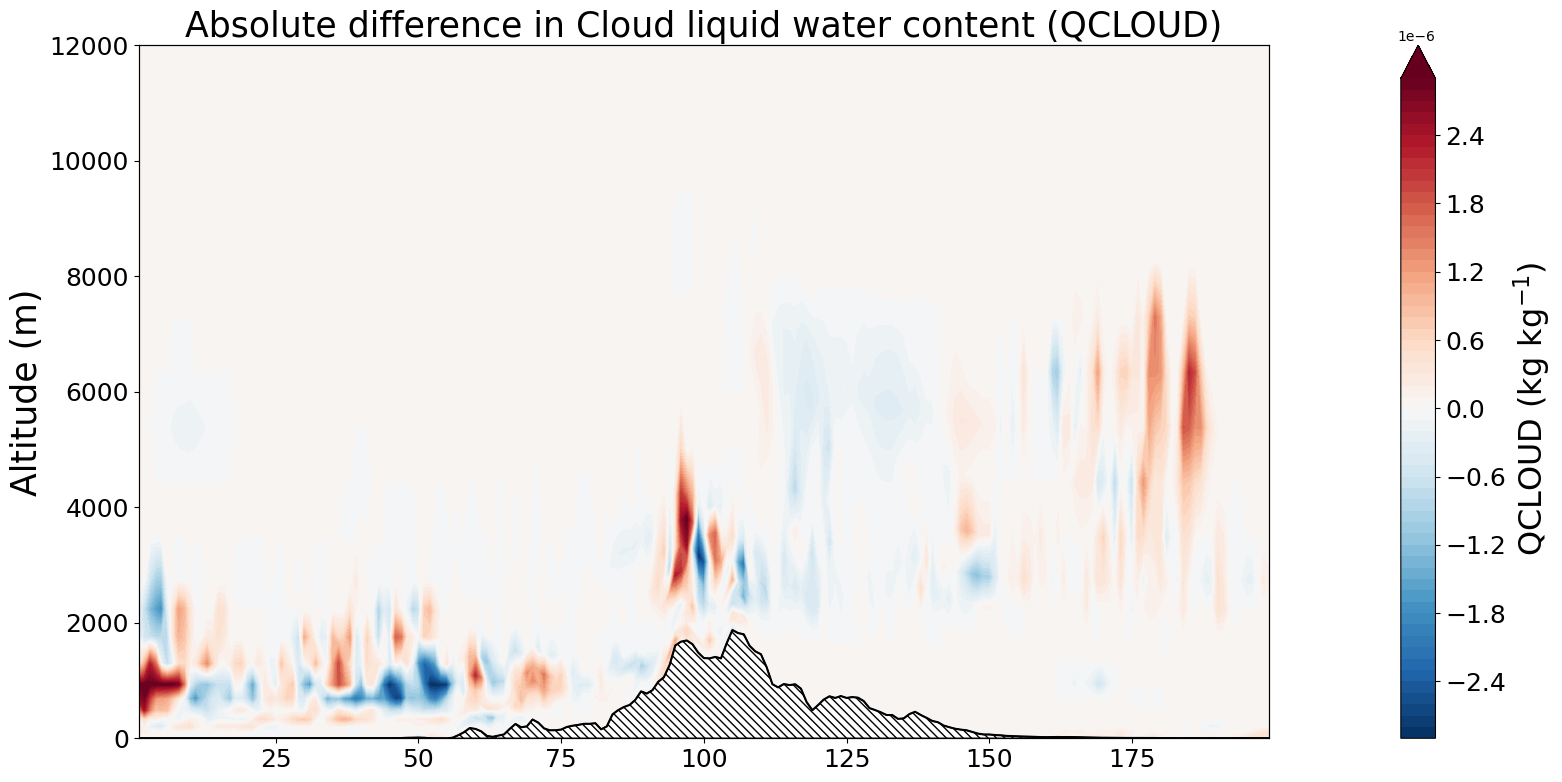

In [13]:
    # extract layer heigth along valley
    hlay = np.zeros((len(h_layer.bottom_top), len(lats)))
    for i in np.arange(len(lats)):
        hlay[:,i] = h_layer[:,int(chi_lats[i]),int(chi_lons[i])]
       
    zlay = hlay + elev
   
    #plotting the results




    #%%
    # along-valley profile conc
    fig = plt.figure(figsize=(17,9))
    ax1 = fig.add_subplot()
    x = np.arange(1,len(lats)+1)
    x = np.tile(x,(32,1))
    levels = np.arange(-2.9e-6,2.9e-6,1e-7)
    cmap_lin = cm.magma_r
    cmap_nonlin = nlcmap(cmap_lin, levels)
   
    profile_plot = ax1.contourf(x,zlay,profile,
                                levels,
                                cmap='RdBu_r', extend='max')
    cbar = plt.colorbar(profile_plot, fraction = 0.042, pad = 0.1)
    cbar.set_label('QCLOUD (kg kg$^{-1}$)', fontsize=23, y=0.5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=18)
    ax1.set(xlim=(1,len(lats)))
    ax1.set(ylim=(0,12000))
    ax1.set_ylabel("Altitude (m)", fontsize=25)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    cbar.ax.tick_params(labelsize=18)
   
    ax2=ax1.twinx()
    ax2.plot(x[0],elev,'k')
    ax2.fill_between(x[0], elev, color= 'none', hatch="\\\\\\\\",edgecolor="black")
    ax2.set(ylim=(0,12000))
    ax2.set_yticks([])
    ax1.set_title('Absolute difference in Cloud liquid water content (QCLOUD)', fontsize = 25)  

In [14]:
np.min(profile)

-2.9e-06

In [15]:
np.max(profile)

2.9e-06